# Locality-Sensitive Hashing (LSH) with Weighted MinHash for DNA Analysis



**Name:** Farzan Rahmani

**Student Number:** 403210725



This notebook explores advanced DNA similarity analysis using Locality-Sensitive Hashing (LSH) and Weighted MinHash. It includes:

1. **Weighted MinHash**: Incorporates k-mer weights based on frequency for enhanced similarity computation.
2. **LSH Bands**: Improves efficiency by narrowing down candidate sequence pairs using signature partitioning.
3. **Real-World Applications**:
   - Genome alignment: Identify the most similar sequence to a reference.
   - Duplicate detection: Detect sequences with high similarity.

### Workflow:
- **Step 1**: Generate a random DNA sequence and create mutated variants.
- **Step 2**: Extract k-mers and assign weights based on their frequency.
- **Step 3**: Compute Weighted MinHash signatures for the reference and dataset sequences.
- **Step 4**: Partition signatures into LSH bands and compute Jaccard similarity.
- **Step 5**: Apply results to real-world applications (genome alignment and duplicate detection).


### Import Libraries


In [1]:
import random
import hashlib
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# fix seeds for reproducibility
random.seed(2)
np.random.seed(2)

## Step 1: Dataset Generation

### Objective:
Generate a synthetic DNA dataset for similarity analysis. This includes:
- A **reference sequence**: A random DNA sequence of a specified length.
- A **dataset**: A list of DNA sequences derived from the reference sequence by introducing random mutations.

### Instructions for Implementation:
1. Create a function to generate a random DNA sequence. Use `random.choices` to randomly select characters from 'A', 'C', 'G', and 'T'.
2. Create a function to introduce mutations into a DNA sequence:
   - Replace a random number of characters in the sequence with different nucleotides.
   - Ensure the mutations do not revert to the original character.

### Example:
- Generate a reference DNA sequence of 1000 characters.
- Create 20 mutated sequences with 50–150 mutations each.


In [3]:
def generate_dna_sequence(length):
    """
    Generates a random DNA sequence of given length.
    :param length: Length of the DNA sequence.
    :return: Random DNA sequence of ACGT.
    """
    return ''.join(random.choices('ACGT', k=length))

def mutate_sequence(sequence, num_mutations):
    """
    Introduces random mutations in a DNA sequence.
    :param sequence: Original DNA sequence.
    :param num_mutations: Number of mutations to introduce.
    :return: Mutated DNA sequence.
    """
    sequence = list(sequence)
    for _ in range(num_mutations):
        idx = random.randint(0, len(sequence) - 1)
        original = sequence[idx]
        mutation = random.choice([n for n in 'ACGT' if n != original])
        sequence[idx] = mutation
    return ''.join(sequence)

# Generate reference sequence and dataset
reference_seq = generate_dna_sequence(1000)

dataset = [mutate_sequence(reference_seq, random.randint(10, 50)) for _ in range(40)] # params mentioned in code
# dataset = [mutate_sequence(reference_seq, random.randint(50, 150)) for _ in range(20)] # params mentioned in markdown text

print(f"{reference_seq}\n")

for i in range(len(dataset)):
    print(dataset[i])

TTAATGGCGGGACCGTTGCCAACCCTGGAACAGTGATTGTTTCTTATGCGCTGTCTTCGTGCACGATCTCTGGGGGCAGTGATGTAGAGCATAGTAATCGACAGATAGACTAAGCATAACGGACACTGTTTGCAGCACTAGCGATCGCAGAAAAAGGTTTACCGGTGCCGAACAGAAAAAGCCGATTGCGGACGAATCGTGCTCAGACTGACCCAGACCTATAGCCTCAAATGTGAGTGCCCTCGCTTTTCACCCGTGTACTACAATTGACAGGCGAGTTAGGCTCGCTTGACAGTAGCCGTGCTCGGTTAGCGTGACGTGTATGGTTATTAGGATAGCCGCATAACTGTCGCCGAATATTCGTTAACCCAGTCGCCTCGCGTATCGTGCTAGCGTTGCACACTATCCCACACCTTCGTCAAAGCCTATGCTCTTGGTGTTTTTCGGCCATCCTATAACCTTTCGATCCGACTAAACCCCAAGCCTAATCTAGTCTGCTCCGCTGGGTTTCCGAATATGTACTAACAAGATGATACGAGAATTGGTACAAAAAACGTTGGTAATGACCCCCTTGCCTTAGGGAGAAGGGGGCATTTGAAAGGATTTCCATGCTGCCGCGAGCTACGCGTATGTCCCCCACACGCAGTAGGTGCATCATACCCGCCCTAGAAGCAGTGCTTACTTAGTGGGAAAGAGCCTCCCAAGTATGAGCGAGGTGGGAACAACGGGTAGAGCACGCTCCTGATCTGTTGTACTAGTGTAGGCCTAAGTTGCTAATTCTAGAAAACGCGAGGCTACCCTGGCCTTGAGACAGTGGCCCCCATTTGACTTGGGAGCTCGGGCTTCGTGGTAGGCTTCGTGCTCAGGCCTTCTGCGTTGGCACATCGGATCAGCTCAAACGACCTTTGGAGACTGGCCGGATTAATGAGATGGACCCAAGTTGTAAGAATAACTATCGCATATTCTAACATGTCATACAGCAACTAAGGTGTATAAATGT

## Step 2: Weighted Shingling

### Objective:
Extract k-mers from DNA sequences and calculate their frequencies to assign weights.

### Instructions for Implementation:
1. Create a function to extract all overlapping substrings of length `k` from a DNA sequence. These substrings are called **k-mers**.
2. Count the frequency of each k-mer in the sequence and store these counts as weights in a dictionary.

### Example:
For the sequence `ACTGACTG` and `k=3`:
- Extract k-mers: `['ACT', 'CTG', 'TGA', 'GAC', 'ACT', 'CTG']`
- Count frequencies: `{'ACT': 2, 'CTG': 2, 'TGA': 1, 'GAC': 1}`


In [4]:
from collections import Counter

def generate_weighted_kmers(sequence, k):
    """
    Generates k-mers and their weights based on frequency.
    """
    kmers = [sequence[i:i + k] for i in range(len(sequence) - k + 1)]
    return dict(Counter(kmers))

k = 6
reference_kmers = generate_weighted_kmers(reference_seq, k)
dataset_kmers = [generate_weighted_kmers(seq, k) for seq in dataset]


print(dataset_kmers)

[{'TTAATG': 1, 'TAATGG': 1, 'AATGGC': 1, 'ATGGCG': 1, 'TGGCGG': 1, 'GGCGGG': 1, 'GCGGGA': 1, 'CGGGAC': 1, 'GGGACC': 1, 'GGACCG': 1, 'GACCGT': 1, 'ACCGTT': 1, 'CCGTTG': 1, 'CGTTGC': 2, 'GTTGCC': 1, 'TTGCCA': 1, 'TGCCAA': 1, 'GCCAAC': 1, 'CCAACC': 1, 'CAACCC': 1, 'AACCCT': 1, 'ACCCTG': 1, 'CCCTGG': 1, 'CCTGGA': 1, 'CTGGAA': 1, 'TGGAAC': 1, 'GGAACA': 2, 'GAACAG': 2, 'AACAGT': 1, 'ACAGTG': 2, 'CAGTGA': 2, 'AGTGAT': 2, 'GTGATT': 1, 'TGATTC': 1, 'GATTCT': 1, 'ATTCTT': 1, 'TTCTTT': 1, 'TCTTTC': 1, 'CTTTCT': 1, 'TTTCTT': 1, 'TTCTTA': 1, 'TCTTAT': 1, 'CTTATG': 1, 'TTATGC': 1, 'TATGCG': 2, 'ATGCGC': 1, 'TGCGCT': 1, 'GCGCTG': 1, 'CGCTGT': 1, 'GCTGTC': 1, 'CTGTCT': 1, 'TGTCTT': 1, 'GTCTTC': 1, 'TCTTCG': 1, 'CTTCGT': 3, 'TTCGTG': 3, 'TCGTGC': 3, 'CGTGCA': 1, 'GTGCAC': 1, 'TGCACG': 1, 'GCACGT': 1, 'CACGTT': 1, 'ACGTTC': 1, 'CGTTCT': 1, 'GTTCTC': 1, 'TTCTCT': 1, 'TCTCTG': 1, 'CTCTGG': 1, 'TCTGGG': 1, 'CTGGGG': 1, 'TGGGGT': 1, 'GGGGTC': 1, 'GGGTCA': 1, 'GGTCAG': 1, 'GTCAGT': 1, 'TCAGTG': 2, 'GTGATG': 

## Step 3: Weighted MinHash

### Objective:
Generate compact signatures for DNA sequences using Weighted MinHash. These signatures allow fast approximate similarity computation.

### Instructions for Implementation:
1. Generate multiple independent hash functions:
   - Each hash function should map a k-mer into a fixed-size bucket range.
   - Use Python's `hashlib` to create hash functions based on a unique seed.

2. Compute a Weighted MinHash signature for a DNA sequence:
   - For each hash function:
     - Compute the hash value of all k-mers in the sequence.
     - Divide each hash value by the corresponding k-mer's weight (frequency).
     - Select the smallest weighted hash value.

3. Return the MinHash signature as a list of the smallest hash values across all hash functions.

### Example:
For k-mers `{'ACT': 2, 'CTG': 1}` and hash functions `h1` and `h2`:
- Compute hash values: `h1(ACT) = 50, h1(CTG) = 30`
- Compute weighted values: `50/2 = 25, 30/1 = 30`
- MinHash for `h1`: `25`


In [5]:
import hashlib

def generate_hash_functions(num_hashes, max_bucket):
    """
    Generates multiple independent hash functions.
    """
    # def hash_function(seed):
    #     return lambda x: int(hashlib.md5((str(seed) + x).encode('utf-8')).hexdigest(), 16) % max_bucket
    # return [hash_function(i) for i in range(num_hashes)]

    hash_funcs = []
    for i in range(num_hashes):
        hash_func = lambda kmer, i=i: (int(hashlib.sha256(f"{i}{kmer}".encode()).hexdigest(), 16) % max_bucket)
        hash_funcs.append(hash_func)
    return hash_funcs

def weighted_minhash_signature(weighted_kmers, hash_functions):
    """
    Generates a Weighted MinHash signature for a set of weighted k-mers.
    """
    signature = []
    for h in hash_functions:
        min_val = float('inf')
        for kmer, weight in weighted_kmers.items():
            val = h(kmer) / weight
            min_val = min(min_val, val)
        signature.append(min_val)
    return signature

# Generate hash functions
num_hashes = 50
max_bucket = 2**32 - 1
hash_functions = generate_hash_functions(num_hashes, max_bucket)

# Compute Weighted MinHash signatures
reference_signature = weighted_minhash_signature(reference_kmers, hash_functions)
dataset_signatures = [weighted_minhash_signature(kmers, hash_functions) for kmers in dataset_kmers]

print(f"Reference Signature: {reference_signature}")
for i, signature in enumerate(dataset_signatures):
    print(f"Dataset Signature {i}: {signature}")


Reference Signature: [838957.5, 11120700.0, 12334051.0, 11991254.0, 2162755.0, 40849.0, 3778939.0, 1617777.0, 2327507.0, 6018721.0, 870501.0, 53786.0, 3599006.0, 1890661.0, 12630775.0, 69440.0, 4997462.0, 1376910.0, 1667097.0, 2142979.0, 1549442.0, 10906375.0, 284278.0, 4212112.0, 3117558.5, 5793426.0, 4908154.0, 5940684.0, 2149295.0, 398135.0, 4049454.0, 4210325.0, 3216828.0, 687265.5, 1048926.0, 7133079.0, 7647770.0, 1260042.0, 1507670.0, 3601344.0, 4063875.0, 1316774.0, 1034194.0, 155292.0, 1011005.0, 8577710.0, 1333934.0, 3578790.0, 11139720.0, 238249.0]
Dataset Signature 0: [559305.0, 11120700.0, 17147773.0, 12143652.0, 2162755.0, 40849.0, 2742003.0, 1617777.0, 2327507.0, 6018721.0, 870501.0, 6874292.0, 3599006.0, 1890661.0, 12630775.0, 1512601.0, 2498731.0, 102059.0, 6793916.0, 2142979.0, 1549442.0, 1039437.0, 284278.0, 4212112.0, 5408559.0, 5793426.0, 1210931.0, 5940684.0, 8651650.0, 398135.0, 4049454.0, 4210325.0, 1334916.0, 687265.5, 1048926.0, 319617.0, 9489308.0, 1260042.0, 

## Step 4: Locality-Sensitive Hashing (LSH) Bands

### Objective:
Partition MinHash signatures into bands to efficiently identify similar sequences.

### Instructions for Implementation:
1. Split the MinHash signature into `num_bands` equal-sized bands.
2. For each band, compute a hash value for the band (a tuple of signature values).
3. Group sequences into buckets based on the band hash:
   - Sequences in the same bucket are considered similar candidates for further comparison.

### Example:
For a signature `[25, 30, 15, 50]` and `num_bands=2`:
- Split into bands: `[(25, 30), (15, 50)]`
- Compute hash values: `hash((25, 30))`, `hash((15, 50))`


In [6]:
def lsh_buckets(signature, num_bands):
    """
    Partition a MinHash signature into LSH buckets.
    """
    # band_size = len(signature) // num_bands
    # return [hash(tuple(signature[i:i + band_size])) for i in range(0, len(signature), band_size)]

    band_size = len(signature) // num_bands
    assert len(signature) % num_bands == 0, "Signature length must be divisible by num_bands"
    buckets = []
    for band_idx in range(num_bands):
        start = band_idx * band_size
        end = start + band_size
        band = tuple(signature[start:end])
        hasher = hashlib.sha256(str(band).encode())
        buckets.append(hasher.hexdigest())
    return buckets

# Create LSH buckets
num_bands = 10
reference_buckets = lsh_buckets(reference_signature, num_bands)
dataset_buckets = [lsh_buckets(signature, num_bands) for signature in dataset_signatures]

## Step 5: Similarity Computation

### Objective:
Compare sequences based on their Weighted MinHash signatures.

### Instructions for Implementation:
1. Create a function to compute Jaccard similarity between two signatures:
   - Compare the number of matching hash values across all hash functions.
   - Divide the number of matches by the total number of hash functions.

2. Compute similarity scores for all dataset sequences compared to the reference.

### Example:
For two signatures `[25, 30, 15, 50]` and `[25, 35, 15, 55]`:
- Matching hash values: `25, 15`
- Jaccard similarity: `2/4 = 0.5`


In [7]:
def minhash_jaccard_similarity(signature1, signature2):
    """
    Computes Jaccard similarity using MinHash signatures.
    """
    matches = sum(1 for a, b in zip(signature1, signature2) if a == b)
    return matches / len(signature1)


# TODO: Compute similarity scores
similarity_scores = [minhash_jaccard_similarity(reference_signature, sig) for sig in dataset_signatures]
print(f"Similarity Scores: {[round(score, 2) for score in similarity_scores]}")

Similarity Scores: [0.6, 0.64, 0.64, 0.62, 0.9, 0.6, 0.84, 0.94, 0.76, 0.8, 0.82, 0.58, 0.84, 0.54, 0.7, 0.68, 0.76, 0.56, 0.72, 0.74, 0.74, 0.84, 0.64, 0.6, 0.62, 0.46, 0.56, 0.74, 0.88, 0.58, 0.7, 0.5, 0.76, 0.74, 0.5, 0.68, 0.66, 0.6, 0.72, 0.8]


## Step 6: Visualization

### Objective:
Plot similarity scores for each dataset sequence compared to the reference.

### Instructions for Implementation:
1. Use a bar chart to display similarity scores.
2. Label the x-axis with sequence indices and the y-axis with similarity scores.




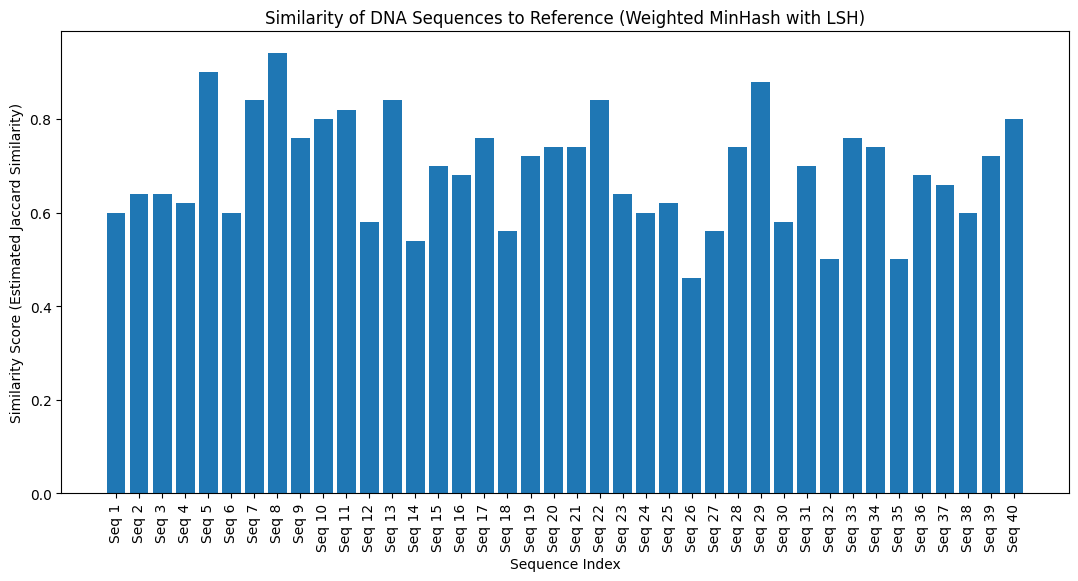

In [8]:
# TODO
plt.figure(figsize=(13, 6))
plt.bar(range(1, len(similarity_scores) + 1), similarity_scores)
plt.xticks(range(1, len(similarity_scores) + 1), [f"Seq {i}" for i in range(1, len(similarity_scores) + 1)], rotation = 90)
plt.xlabel('Sequence Index')
plt.ylabel('Similarity Score (Estimated Jaccard Similarity)')
plt.title('Similarity of DNA Sequences to Reference (Weighted MinHash with LSH)')
plt.show()

## Step 7: Real-World Applications

### Applications:
1. **Genome Alignment**:
   - Identify the sequence in the dataset most similar to the reference.

2. **Duplicate Detection**:
   - Detect nearly identical sequences based on a similarity threshold (e.g., 0.9).

### Instructions for Implementation:
1. Sort or filter sequences based on their similarity scores.
2. Use the results to identify the most similar sequence or detect duplicates.


In [10]:
# TODO
# Genome Alignment
max_similarity = max(similarity_scores)
max_index = similarity_scores.index(max_similarity)
print(f"Real-World Application 1: Genome Alignment")
print(f"Sequence {max_index + 1} is most similar to the reference. (1-base indexing)")

print()

# Duplicate Detection
threshold = 0.9
duplicates = [i for i, score in enumerate(similarity_scores) if score >= threshold]
print(f"Real-World Application 2: Duplicate Sequence Detection")
duplicates = [i + 1 for i in duplicates] # 0-base to 1-base
print(f"Sequences {duplicates} are potential duplicates.  (1-base indexing)")

Real-World Application 1: Genome Alignment
Sequence 8 is most similar to the reference. (1-base indexing)

Real-World Application 2: Duplicate Sequence Detection
Sequences [5, 8] are potential duplicates.  (1-base indexing)
